In [226]:
import warnings
warnings.filterwarnings('ignore')


import gym, gym_walk, gym_aima 
import numpy as np 
from pprint import pprint 
from tqdm import tqdm_notebook as tqdm 

from itertools import cycle, count 

import random 
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab 


SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline 

In [227]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize':(15, 8),
    'font.size':24, 
    'legend.fontsize':20, 
    'axes.titlesize': 28, 
    'axes.labelsize': 24, 
    'xtick.labelsize': 20, 
    'ytick.labelsize': 20
}

pylab.rcParams.update(params)
np.set_printoptions(suppress= True)

In [228]:
P

{0: {0: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)],
  1: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)]},
 1: {0: [(0.5, 0, 0.0, True), (0.0, 1, 0.0, False), (0.5, 2, 0.0, False)],
  1: [(0.5, 2, 0.0, False), (0.0, 1, 0.0, False), (0.5, 0, 0.0, True)]},
 2: {0: [(0.5, 1, 0.0, False), (0.0, 2, 0.0, False), (0.5, 3, 0.0, False)],
  1: [(0.5, 3, 0.0, False), (0.0, 2, 0.0, False), (0.5, 1, 0.0, False)]},
 3: {0: [(0.5, 2, 0.0, False), (0.0, 3, 0.0, False), (0.5, 4, 0.0, False)],
  1: [(0.5, 4, 0.0, False), (0.0, 3, 0.0, False), (0.5, 2, 0.0, False)]},
 4: {0: [(0.5, 3, 0.0, False), (0.0, 4, 0.0, False), (0.5, 5, 0.0, False)],
  1: [(0.5, 5, 0.0, False), (0.0, 4, 0.0, False), (0.5, 3, 0.0, False)]},
 5: {0: [(0.5, 4, 0.0, False), (0.0, 5, 0.0, False), (0.5, 6, 1.0, True)],
  1: [(0.5, 6, 1.0, True), (0.0, 5, 0.0, False), (0.5, 4, 0.0, False)]},
 6: {0: [(0.5, 6, 0.0, True), (0.0, 6, 0.0, True), (0.5, 6, 0.0, True)],
  1: [(0.5, 6, 0.0, True), (0.0, 6, 0

In [229]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [230]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [231]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [232]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [233]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, _, done, h = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

In [234]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [235]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [236]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [237]:
def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]
    
    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y, 
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

In [238]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start = -2, log_base = 10):
    decay_steps = int(max_steps* decay_ratio)
    rem_steps = max_steps - decay_steps 
    values = np.logspace(log_start, 0, decay_steps, base = log_base, endpoint = True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value)* values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values 

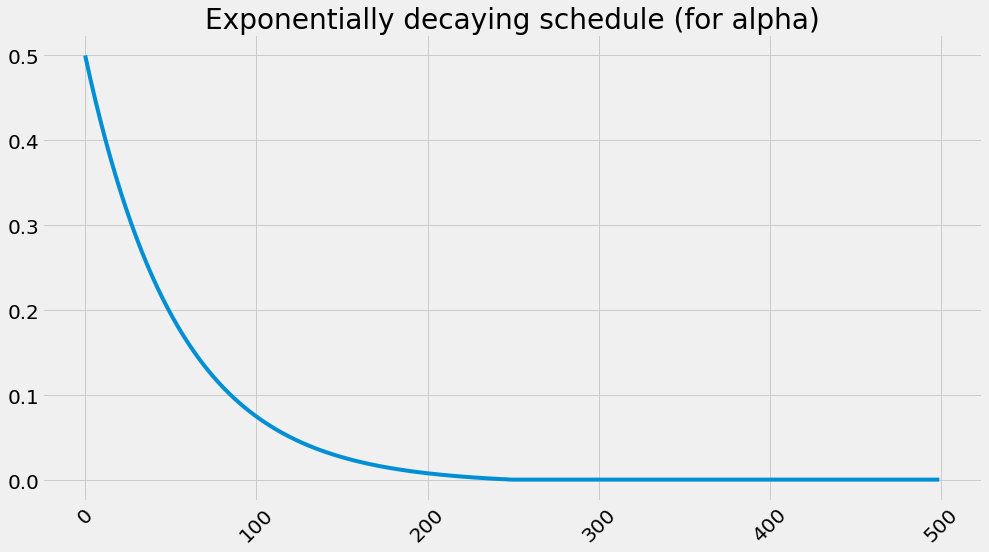

In [239]:
plt.plot(decay_schedule(0.5, 0.001, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation = 45)
plt.show()

### Random walk/Deterministic walk with uniformly random policy

In [240]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.env.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 53.00%. Obtains an average return of 0.5300.


## First visit Monte Carlo Prediction

In [241]:
def generate_trajectory(pi, env, max_steps = 200):
    done, trajectory = False, []

    while not done: 
        state = env.reset()
        for t in count():
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)

            if done: 
                break 
            if t >= max_steps-1: 
                trajectory = []
                break 
            state = next_state

    return np.array(trajectory, np.object)

In [242]:
def mc_prediction(pi, env, gamma = 1.0, init_alpha = 0.5, min_alpha =0.01, alpha_decay_ration = 0.5, n_episodes = 500, max_steps = 200, first_visit = True): 
    nS = env.observation_space.n 
    discounts = np.logspace(0, max_steps, num = max_steps, base = gamma, endpoint = False)


    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ration, n_episodes)

    V = np.zeros(nS, dtype = np.float64)

    V_tract = np.zeros((n_episodes, nS), dtype= np.float64)
    targets = {state:[] for state in range(nS)}

    for e in tqdm(range(n_episodes), leave = False): 
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype = np.bool)

        for t, (state, _, reward, _,_) in enumerate(trajectory):
            if visited[state] and first_visit: 
                continue
            visited[state] = True 

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps]*trajectory[t:, 2])
            targets[state].append(G)
            mc_error = G - V[state]

            V[state] = V[state] + alphas[e]*mc_error 
        V_tract[e] = V 

    return V.copy(), V_tract, targets 

In [243]:
V_fvmcs, V_track_fvmcs = [], []

for seed in tqdm(SEEDS, desc = 'All seeds', leave = True): 
    random.seed(seed); np.random.seed(seed); env.seed(seed) 
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes= n_episodes)
    V_fvmcs.append(V_fvmc); V_track_fvmcs.append(V_track_fvmc)

V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis = 0), np.mean(V_track_fvmcs, axis = 0)
del V_fvmcs; del V_track_fvmcs

In [244]:
print_state_value_function(V_fvmc, P, n_cols= 7)
print()
print_state_value_function(V_fvmc - V_true, P, n_cols = 7, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
|           | 01  0.172 | 02  0.338 | 03  0.509 | 04  0.671 | 05  0.822 |           |

State-value function errors:
|           | 01  0.005 | 02  0.005 | 03  0.009 | 04  0.004 | 05 -0.011 |           |
RMSE: 0.006


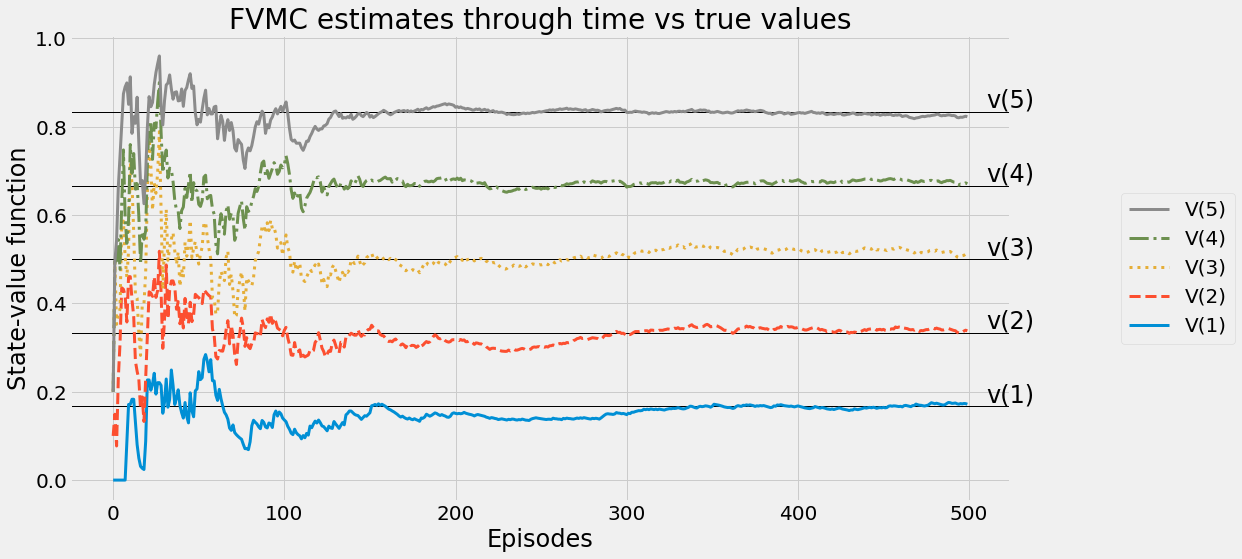

In [245]:
plot_value_function('FVMC estimates through time vs true values', V_track_fvmc, V_true, log = False)

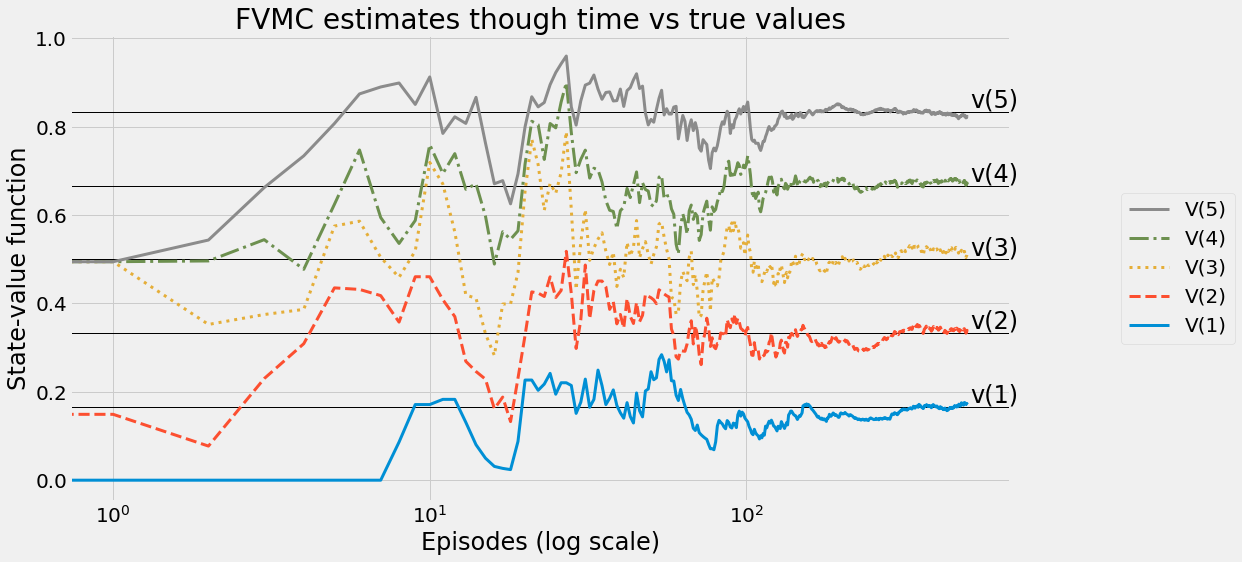

In [246]:
plot_value_function('FVMC estimates though time vs true values', V_track_fvmc, V_true, log = True)

### Every visit Monte Carlo Prediction

In [247]:
V_evmcs, V_track_evmcs = [], []

for seed in tqdm(SEEDS, desc = 'All seeds', leave = True): 
    random.seed(seed); np.random.seed(seed); env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = 

SyntaxError: invalid syntax (<ipython-input-247-7c8ce953b9ed>, line 5)